Installation Dependencies 

IMPORTANT: Make sure you use Python 3.8 - AzureML

In [1]:
!pip install requests_cache
!pip install matplotlib
!pip install seaborn
!pip install openpyxl
!pip install yfinance

print('Ready!!!')

Ready!!!


In [2]:
#import pandas_datareader.data as web
#from pandas_datareader.yahoo.headers import DEFAULT_HEADERS
import datetime
import requests_cache

import calendar

import numpy as np, pandas as pd
import yfinance as yf

# plots
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
print('-'*100)
print('\nVariable definition: ')
# Calculation Period in trading days
PERIOD = 252
# List of tickers required from yahoo finance
LIST_OF_TICKERS = 'BAH CARR AMR CEG TVK.TO UNTC'
#LIST_OF_TICKERS = 'RSP IHI VTI IVV XLV IXJ KBWP QQQ PTF XLK XLY PBS DIA'
#LIST_OF_TICKERS = 'RSP IHI XLV IXJ PTF IYK PBS DIA'
#LIST_OF_TICKERS = 'RSP IHI XLV SMH PTF XLK XLY IYK EWL KBWP IYW XRT PBS DIA VPU XLB IYM GLD NOBL'
# Num of portfolios to simulate
#NUM_PORTFOLIOS = 5_000_000
NUM_PORTFOLIOS = 100_000
# Risk free rate of 0.08% since the time horizon for each portfolio is 1 month before the portfolio is re-adjusted
risk_free_ratio = 0.0008
RISK_FREE = np.log(1+risk_free_ratio)

print('Period   : {}'.format(PERIOD))
print('Tickers  : {}'.format(LIST_OF_TICKERS))
print('Risk free: {}'.format(RISK_FREE))

print('-'*100)

----------------------------------------------------------------------------------------------------

Variable definition: 
Period   : 252
Tickers  : BAH CARR AMR CEG TVK.TO UNTC
Risk free: 0.0007996801705642441
----------------------------------------------------------------------------------------------------


[*********************100%***********************]  6 of 6 completed
----------------------------------------------------------------------------------------------------

Price History:


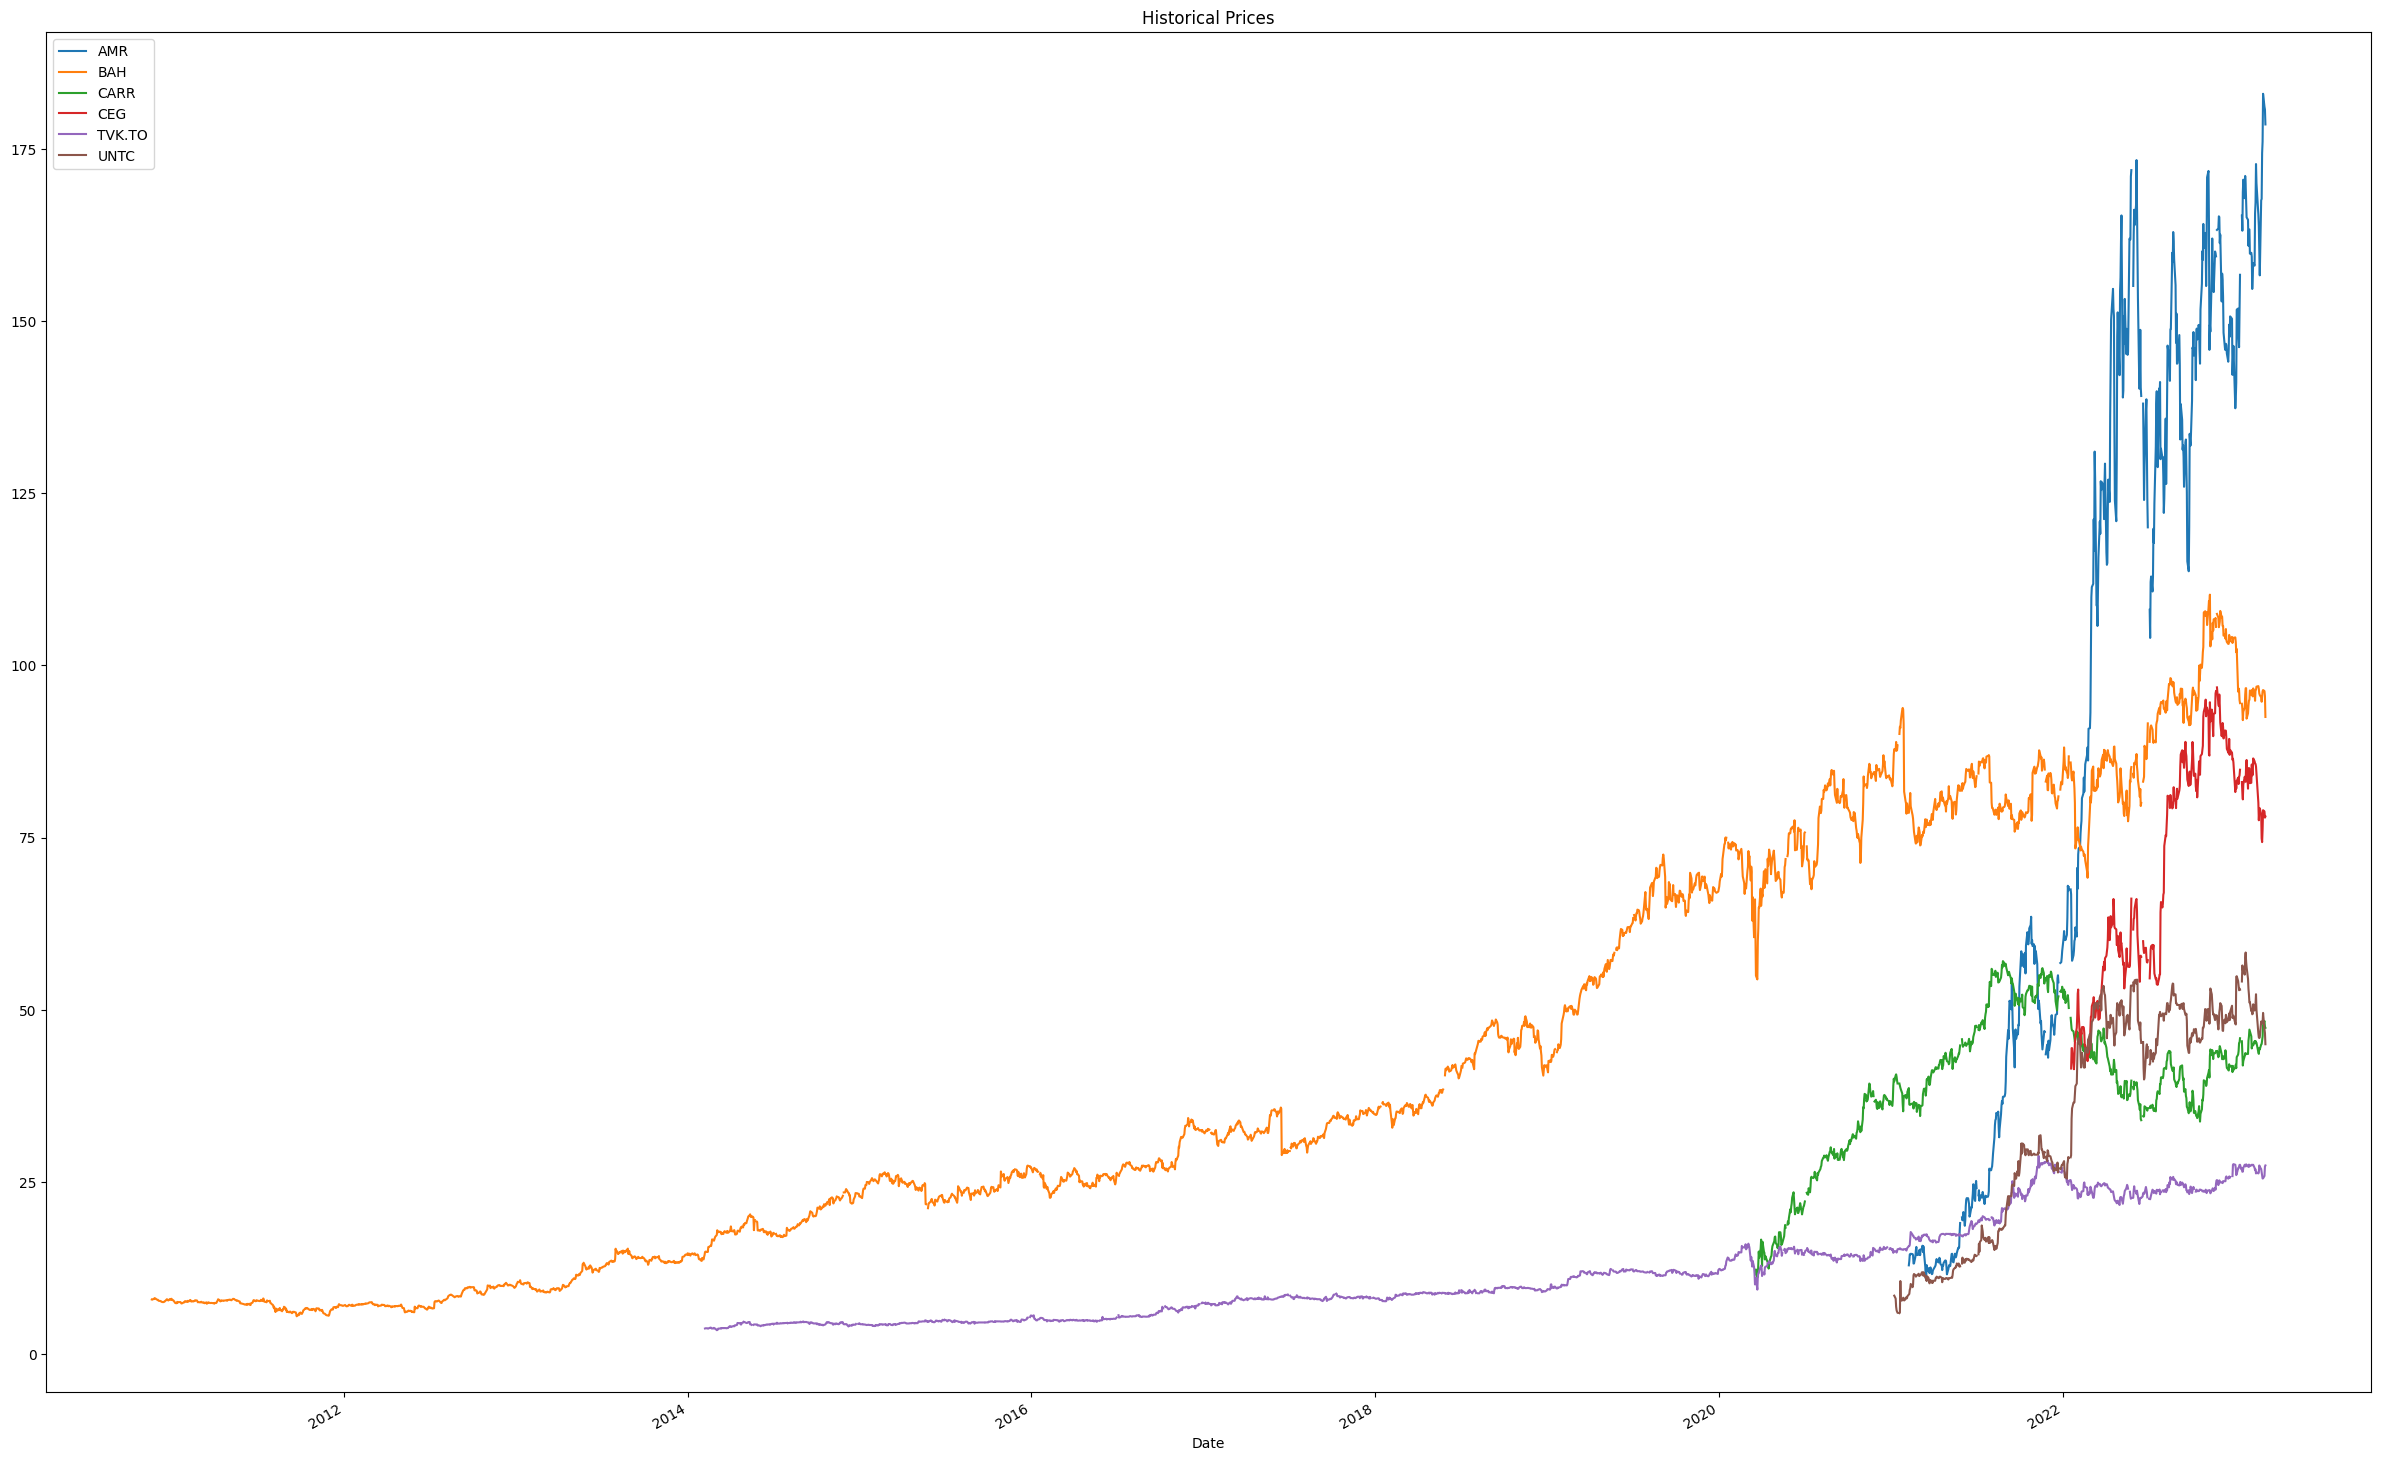

In [6]:
def get_max_period_stock_prices(stock_list):
    """
    stock_list: list, a list of stock symbols
    """
    # pd datareader with yahoo finance, caching query to sql lite file
    # https://openbase.com/python/yfinance/documentation
    #expire_after = datetime.timedelta(days=1)
    #session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)
    #session.headers['User-agent'] = 'my-program/1.0'
    tickers = yf.Tickers(stock_list)#, session=session)

    # get historical market data
    hist = tickers.history(period="max", auto_adjust=False)

    # use adjusted close as daily price
    hist = hist['Adj Close']
    return hist

hist = get_max_period_stock_prices(LIST_OF_TICKERS)

print('-'*100)
print('\nPrice History:')
hist.tail(10)

hist.plot(figsize=(30, 20))
plt.title('Historical Prices');
plt.show()

----------------------------------------------------------------------------------------------------
Historical Returns:


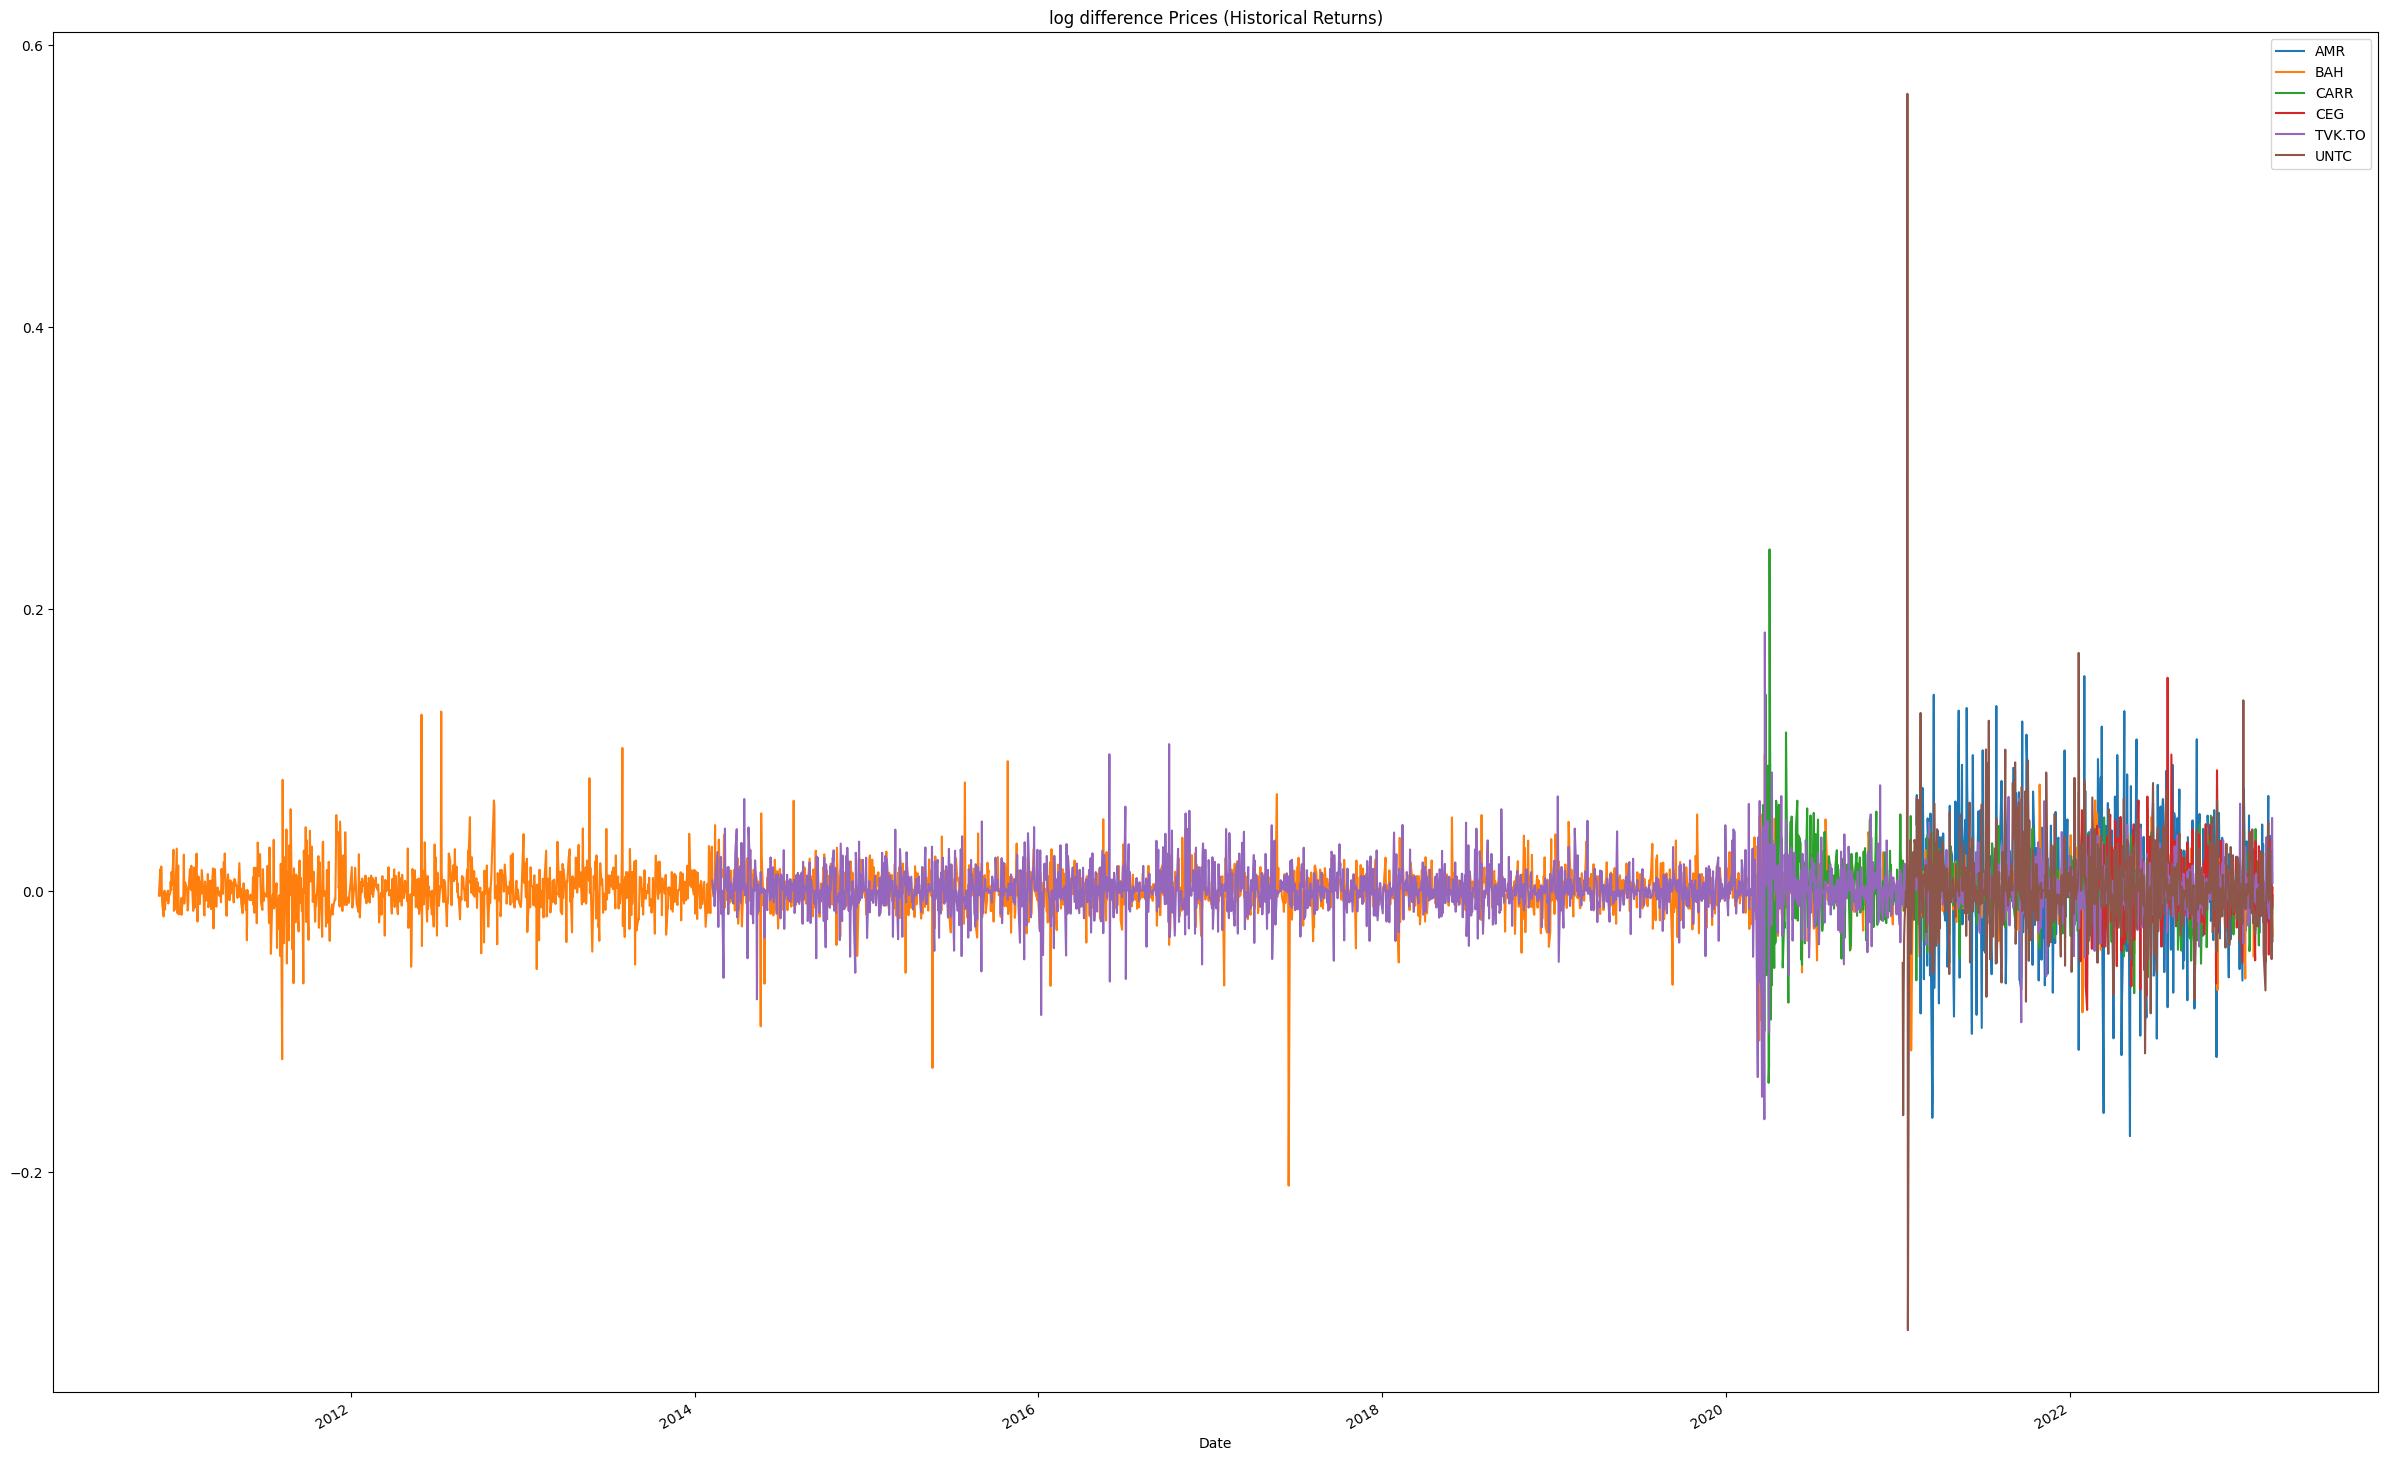

In [7]:
#find % difference and log difference
df = hist.pct_change().apply(lambda x: np.log(1+x))

print('-'*100)
print('Historical Returns:')
df.tail(10)

df.plot(figsize=(30, 20))
plt.title('log difference Prices (Historical Returns)');

----------------------------------------------------------------------------------------------------

Expected Return by Period: 252:
AMR       1.242422
BAH       0.197531
CARR      0.466822
CEG       0.551574
TVK.TO    0.216080
UNTC      0.758365
dtype: float64


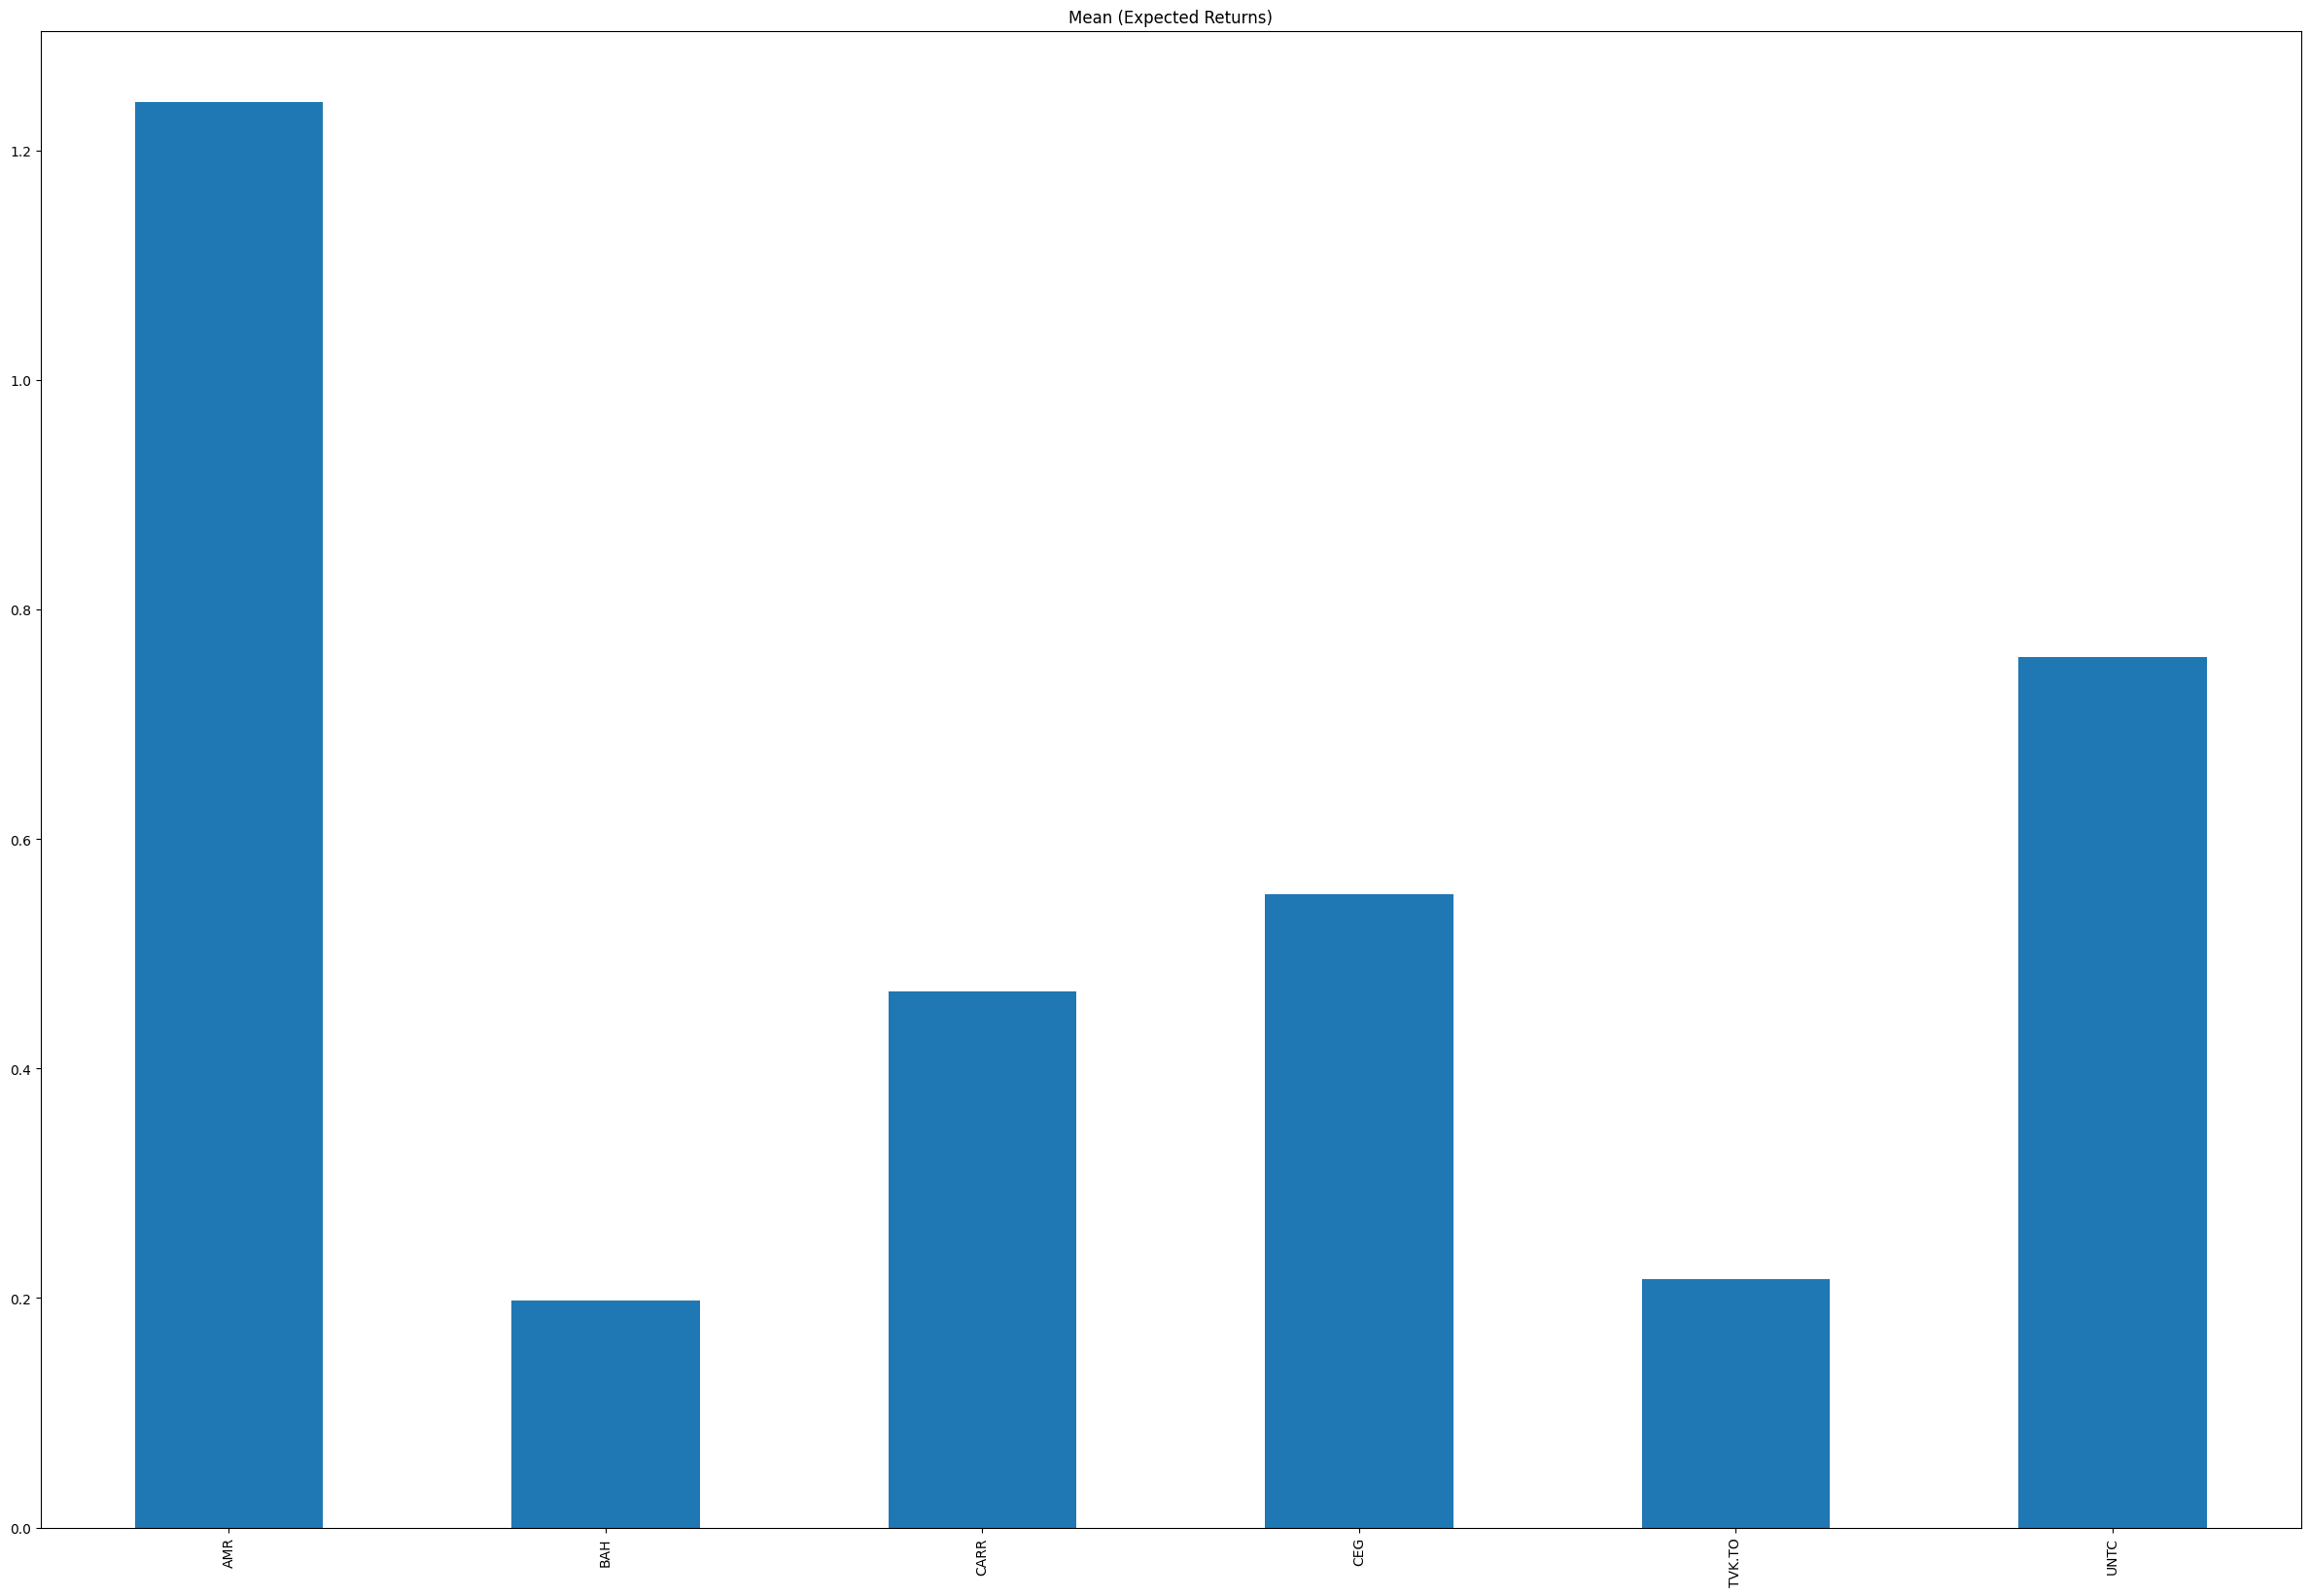

In [8]:
# get average daily return times 365.25 in the year that is extracted from dataset
expected_returns = df.mean() * PERIOD

print('-'*100)
print('\nExpected Return by Period: {}:'.format(PERIOD))
print(expected_returns)

# plot exp return
expected_returns.plot(kind='bar', figsize=(30, 20))
plt.title('Mean (Expected Returns)');

----------------------------------------------------------------------------------------------------

Volatility by Period 252:
AMR       0.705073
BAH       0.270547
CARR      0.412719
CEG       0.448813
TVK.TO    0.293579
UNTC      0.664565
dtype: float64


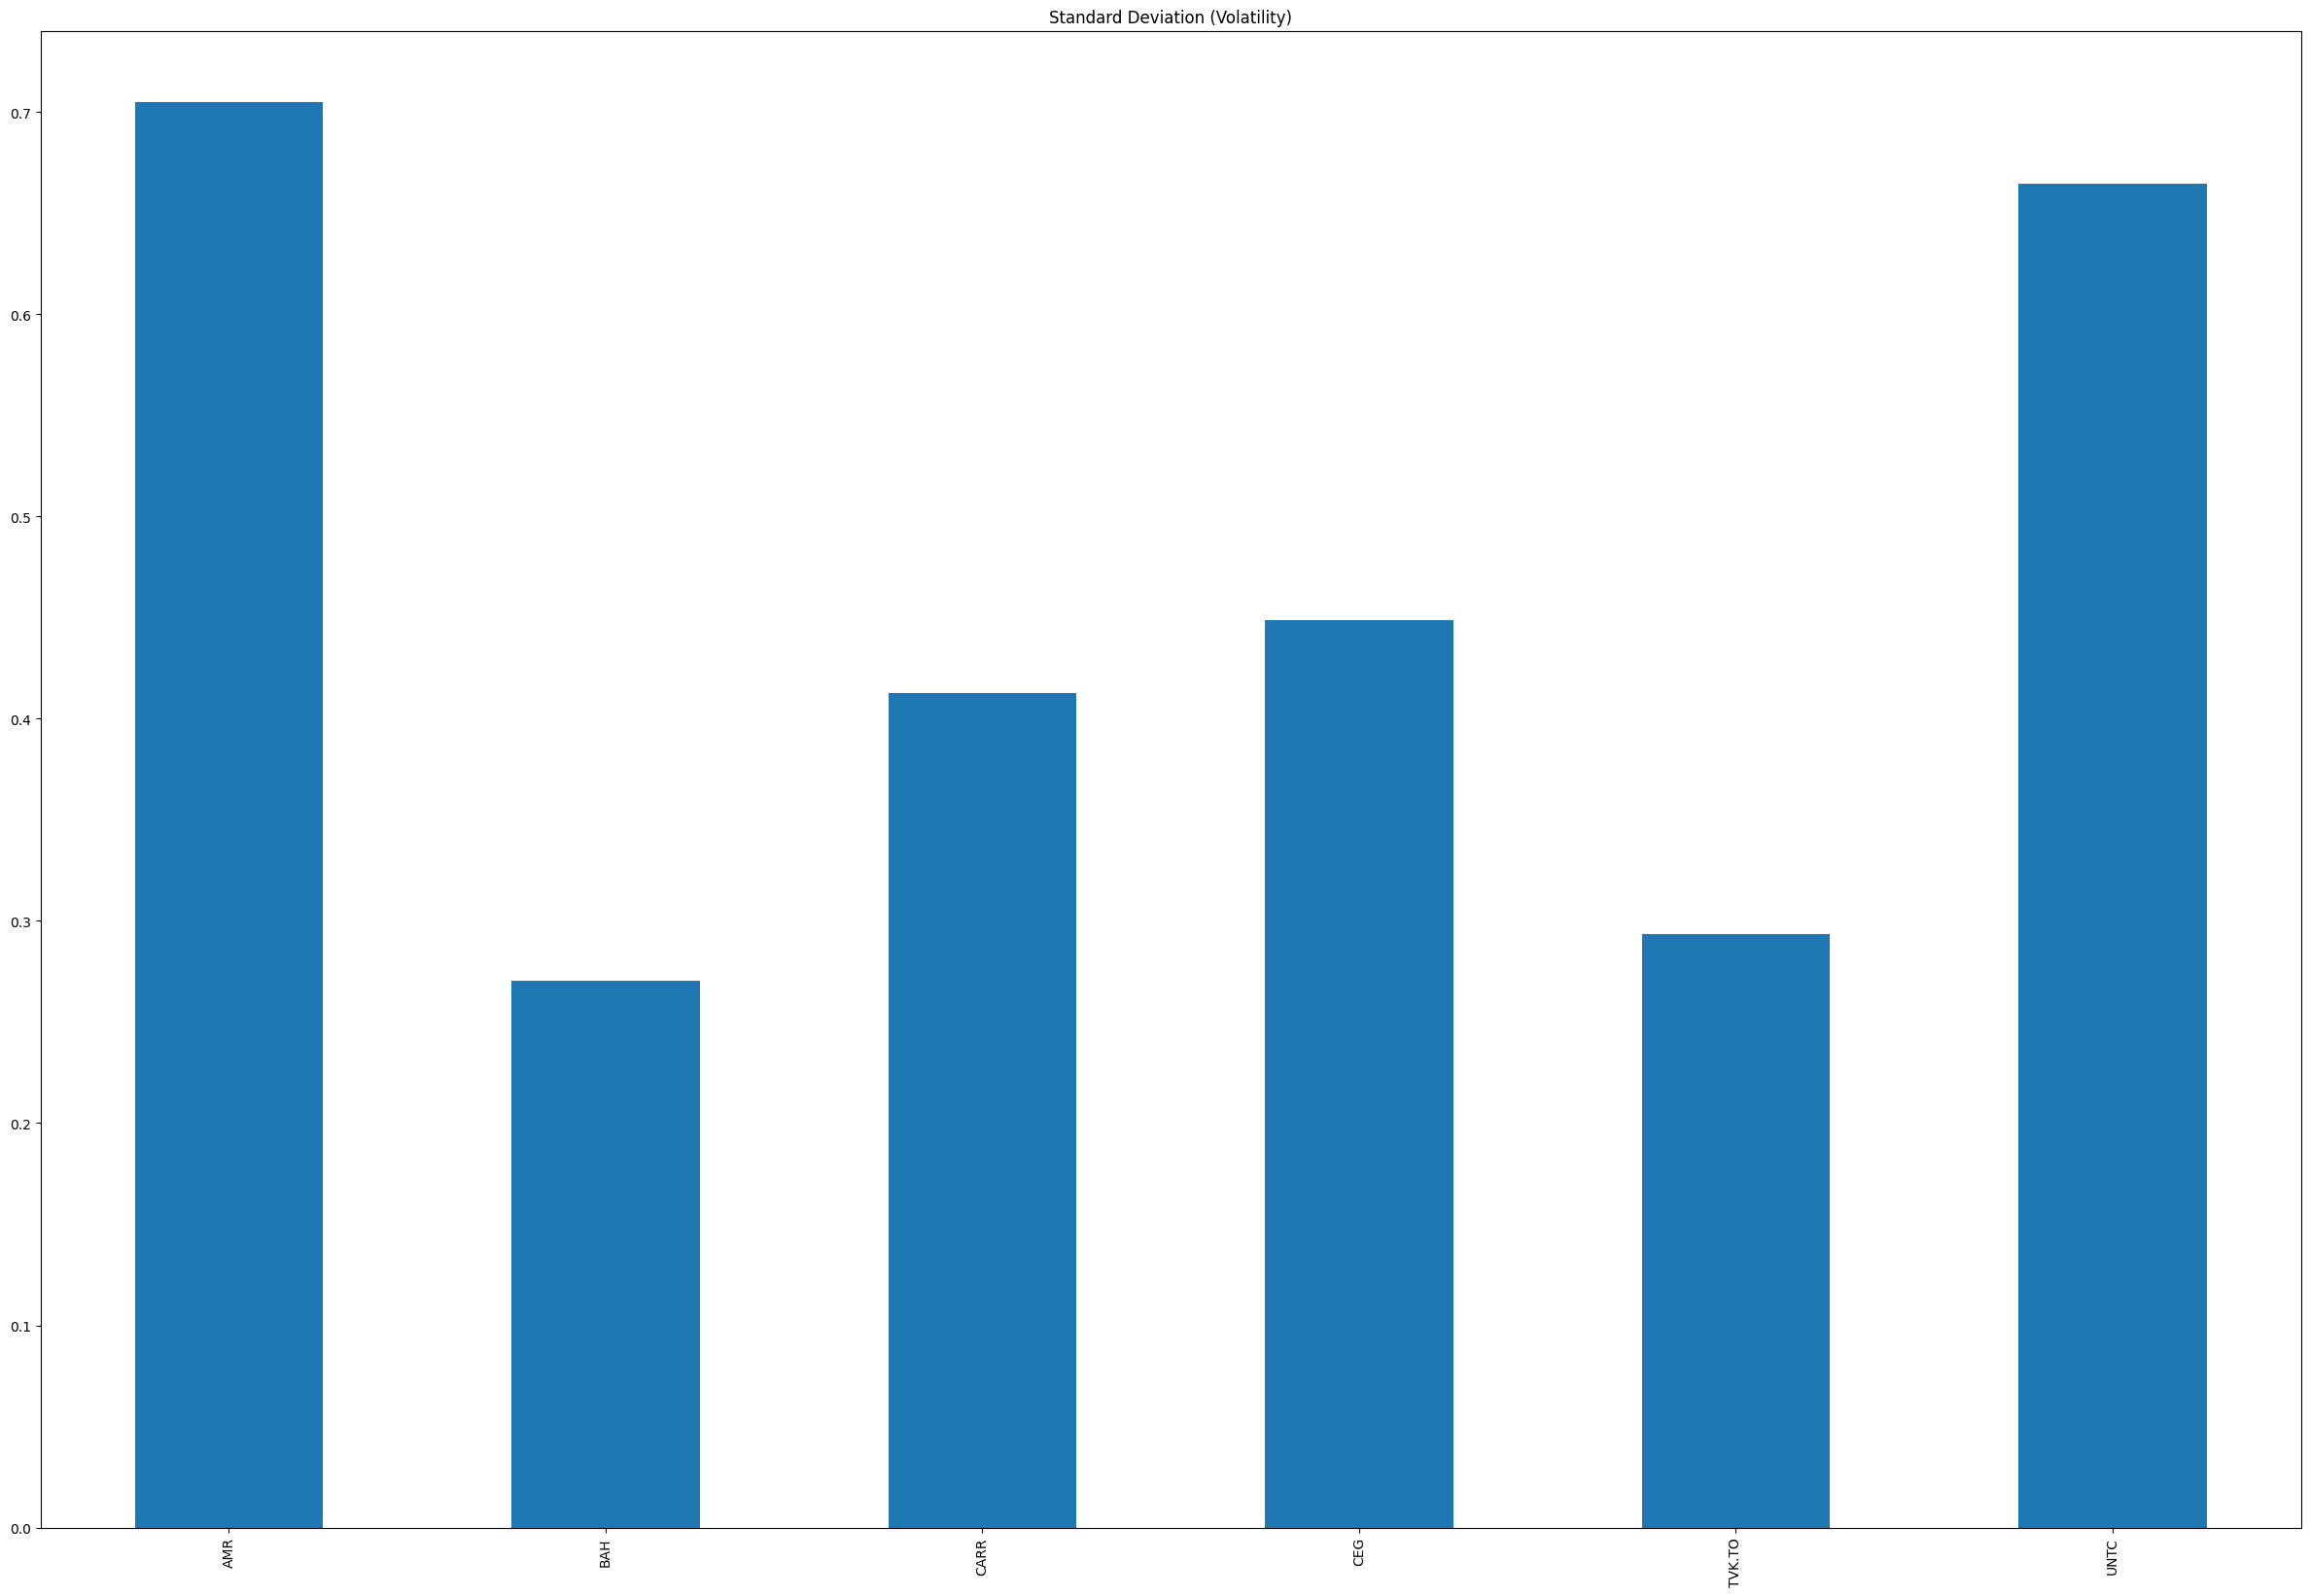

In [9]:
volatility = df.std() * np.sqrt(PERIOD)

print('-'*100)
print('\nVolatility by Period {}:'.format(PERIOD))
print(volatility)

volatility.plot(kind='bar', figsize=(30, 20))
plt.title('Standard Deviation (Volatility)');

In [10]:
variance = df.var() * PERIOD
mean = df.mean() * PERIOD
print('-'*100)
print('\nVariance calculation by Period: {}'.format(PERIOD))
print(variance)

----------------------------------------------------------------------------------------------------

Variance calculation by Period: 252
AMR       0.497128
BAH       0.073196
CARR      0.170337
CEG       0.201433
TVK.TO    0.086189
UNTC      0.441646
dtype: float64


----------------------------------------------------------------------------------------------------

Correlation by Period 252:
             AMR       BAH      CARR       CEG    TVK.TO      UNTC
AMR     0.497128  0.015690  0.041462  0.066749  0.018463  0.067170
BAH     0.015690  0.073196  0.019215  0.036837  0.005449  0.007191
CARR    0.041462  0.019215  0.170337  0.048415  0.025549  0.006043
CEG     0.066749  0.036837  0.048415  0.201433  0.016131  0.056472
TVK.TO  0.018463  0.005449  0.025549  0.016131  0.086189  0.005840
UNTC    0.067170  0.007191  0.006043  0.056472  0.005840  0.441646


Text(0.5, 1.0, 'Correlation')

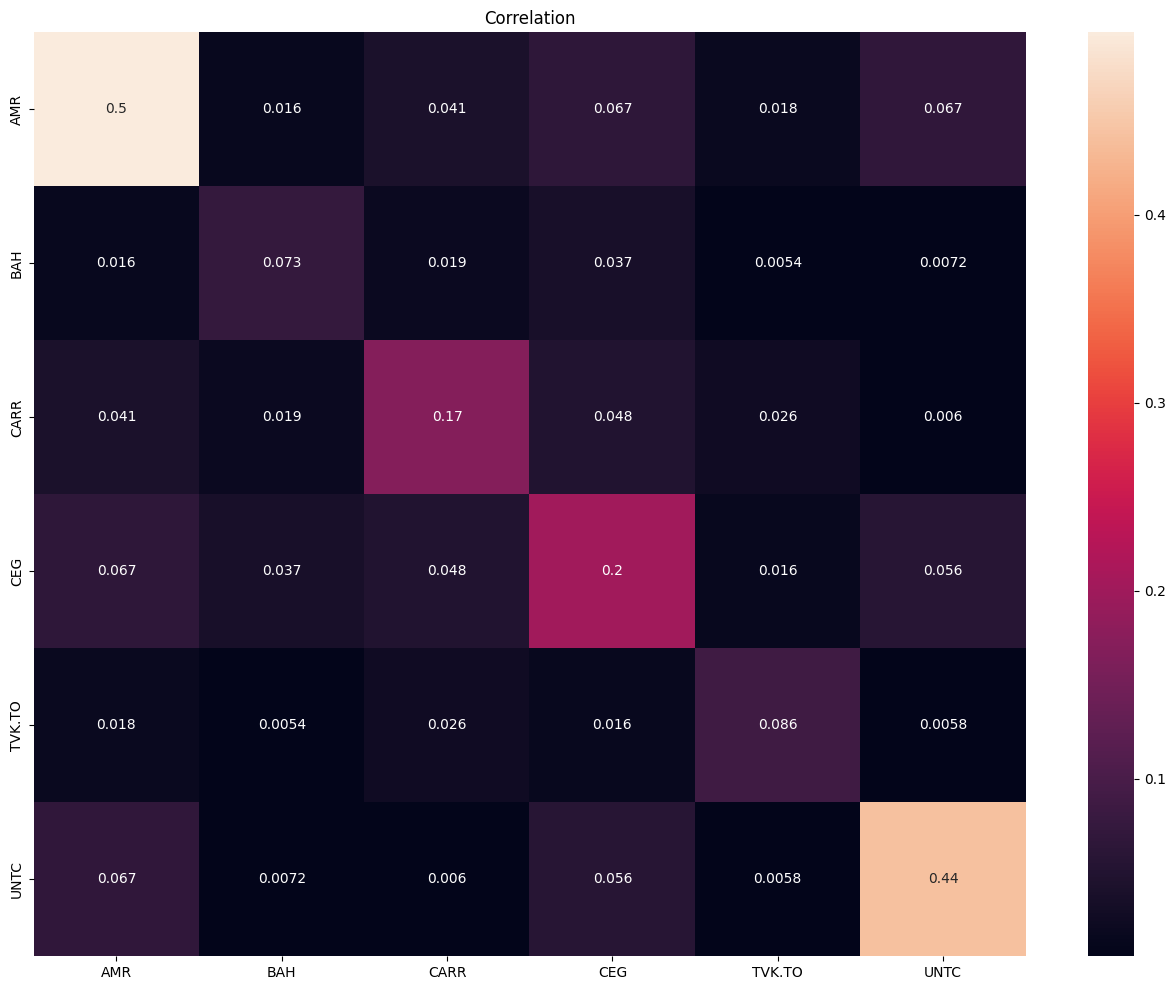

In [11]:
# create the covariance matrix. 
# this will be used later in portfolio construction
correlation = df.cov() * PERIOD
print('-'*100)
print('\nCorrelation by Period {}:'.format(PERIOD))
print(correlation)

#ax = plt.axes()
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(correlation, ax=ax, annot=True)
ax.set_title('Correlation')

In [15]:
pf_returns = []
pf_weights = []
pf_volatility = []
pf_sharpe_ratio = []

# set no. of assets and portfolios to simulate
num_assets = len(df.columns)

print('Calculating of Portfolios: {}'.format(NUM_PORTFOLIOS))
# for each random portfolio, find the return and volatility
for portfolio in range(NUM_PORTFOLIOS):
    if portfolio % 10_000 == 0:
        print('N. of Portfolios calculated {} of {}, calculating...'.format(portfolio, NUM_PORTFOLIOS))
    
    # create random weights
    weights = np.random.random(num_assets)
    weights = weights / np.sum(weights)
    pf_weights.append(weights)
    
    returns = np.dot(weights, expected_returns)
    pf_returns.append(returns)
    
    volatility = np.sqrt(np.dot(weights.T, np.dot(correlation, weights)))
    pf_volatility.append(volatility)
        
    sharpe_ratio = (returns - RISK_FREE) / volatility
    pf_sharpe_ratio.append(sharpe_ratio)

print('Calculation finished: {}'.format(NUM_PORTFOLIOS))

data = {'returns': pf_returns, 'volatility': pf_volatility, 'sharpe_ratio': pf_sharpe_ratio}

for counter, symbol in enumerate(df.columns.tolist()):
    data[symbol + '_weight'] = [w[counter] for w in pf_weights]
    
portfolios = pd.DataFrame(data)

#portfolios.to_csv('./data/portfolios.csv',index=False)
#print('Portfolios saved...')

Calculating of Portfolios: 100000
N. of Portfolios calculated 0 of 100000, calculating...
N. of Portfolios calculated 10000 of 100000, calculating...
N. of Portfolios calculated 20000 of 100000, calculating...
N. of Portfolios calculated 30000 of 100000, calculating...
N. of Portfolios calculated 40000 of 100000, calculating...
N. of Portfolios calculated 50000 of 100000, calculating...
N. of Portfolios calculated 60000 of 100000, calculating...
N. of Portfolios calculated 70000 of 100000, calculating...
N. of Portfolios calculated 80000 of 100000, calculating...
N. of Portfolios calculated 90000 of 100000, calculating...
Calculation finished: 100000


----------------------------------------------------------------------------------------------------

Efficient Frontier:
returns       0.314464
volatility    0.192888
Name: 84304, dtype: float64


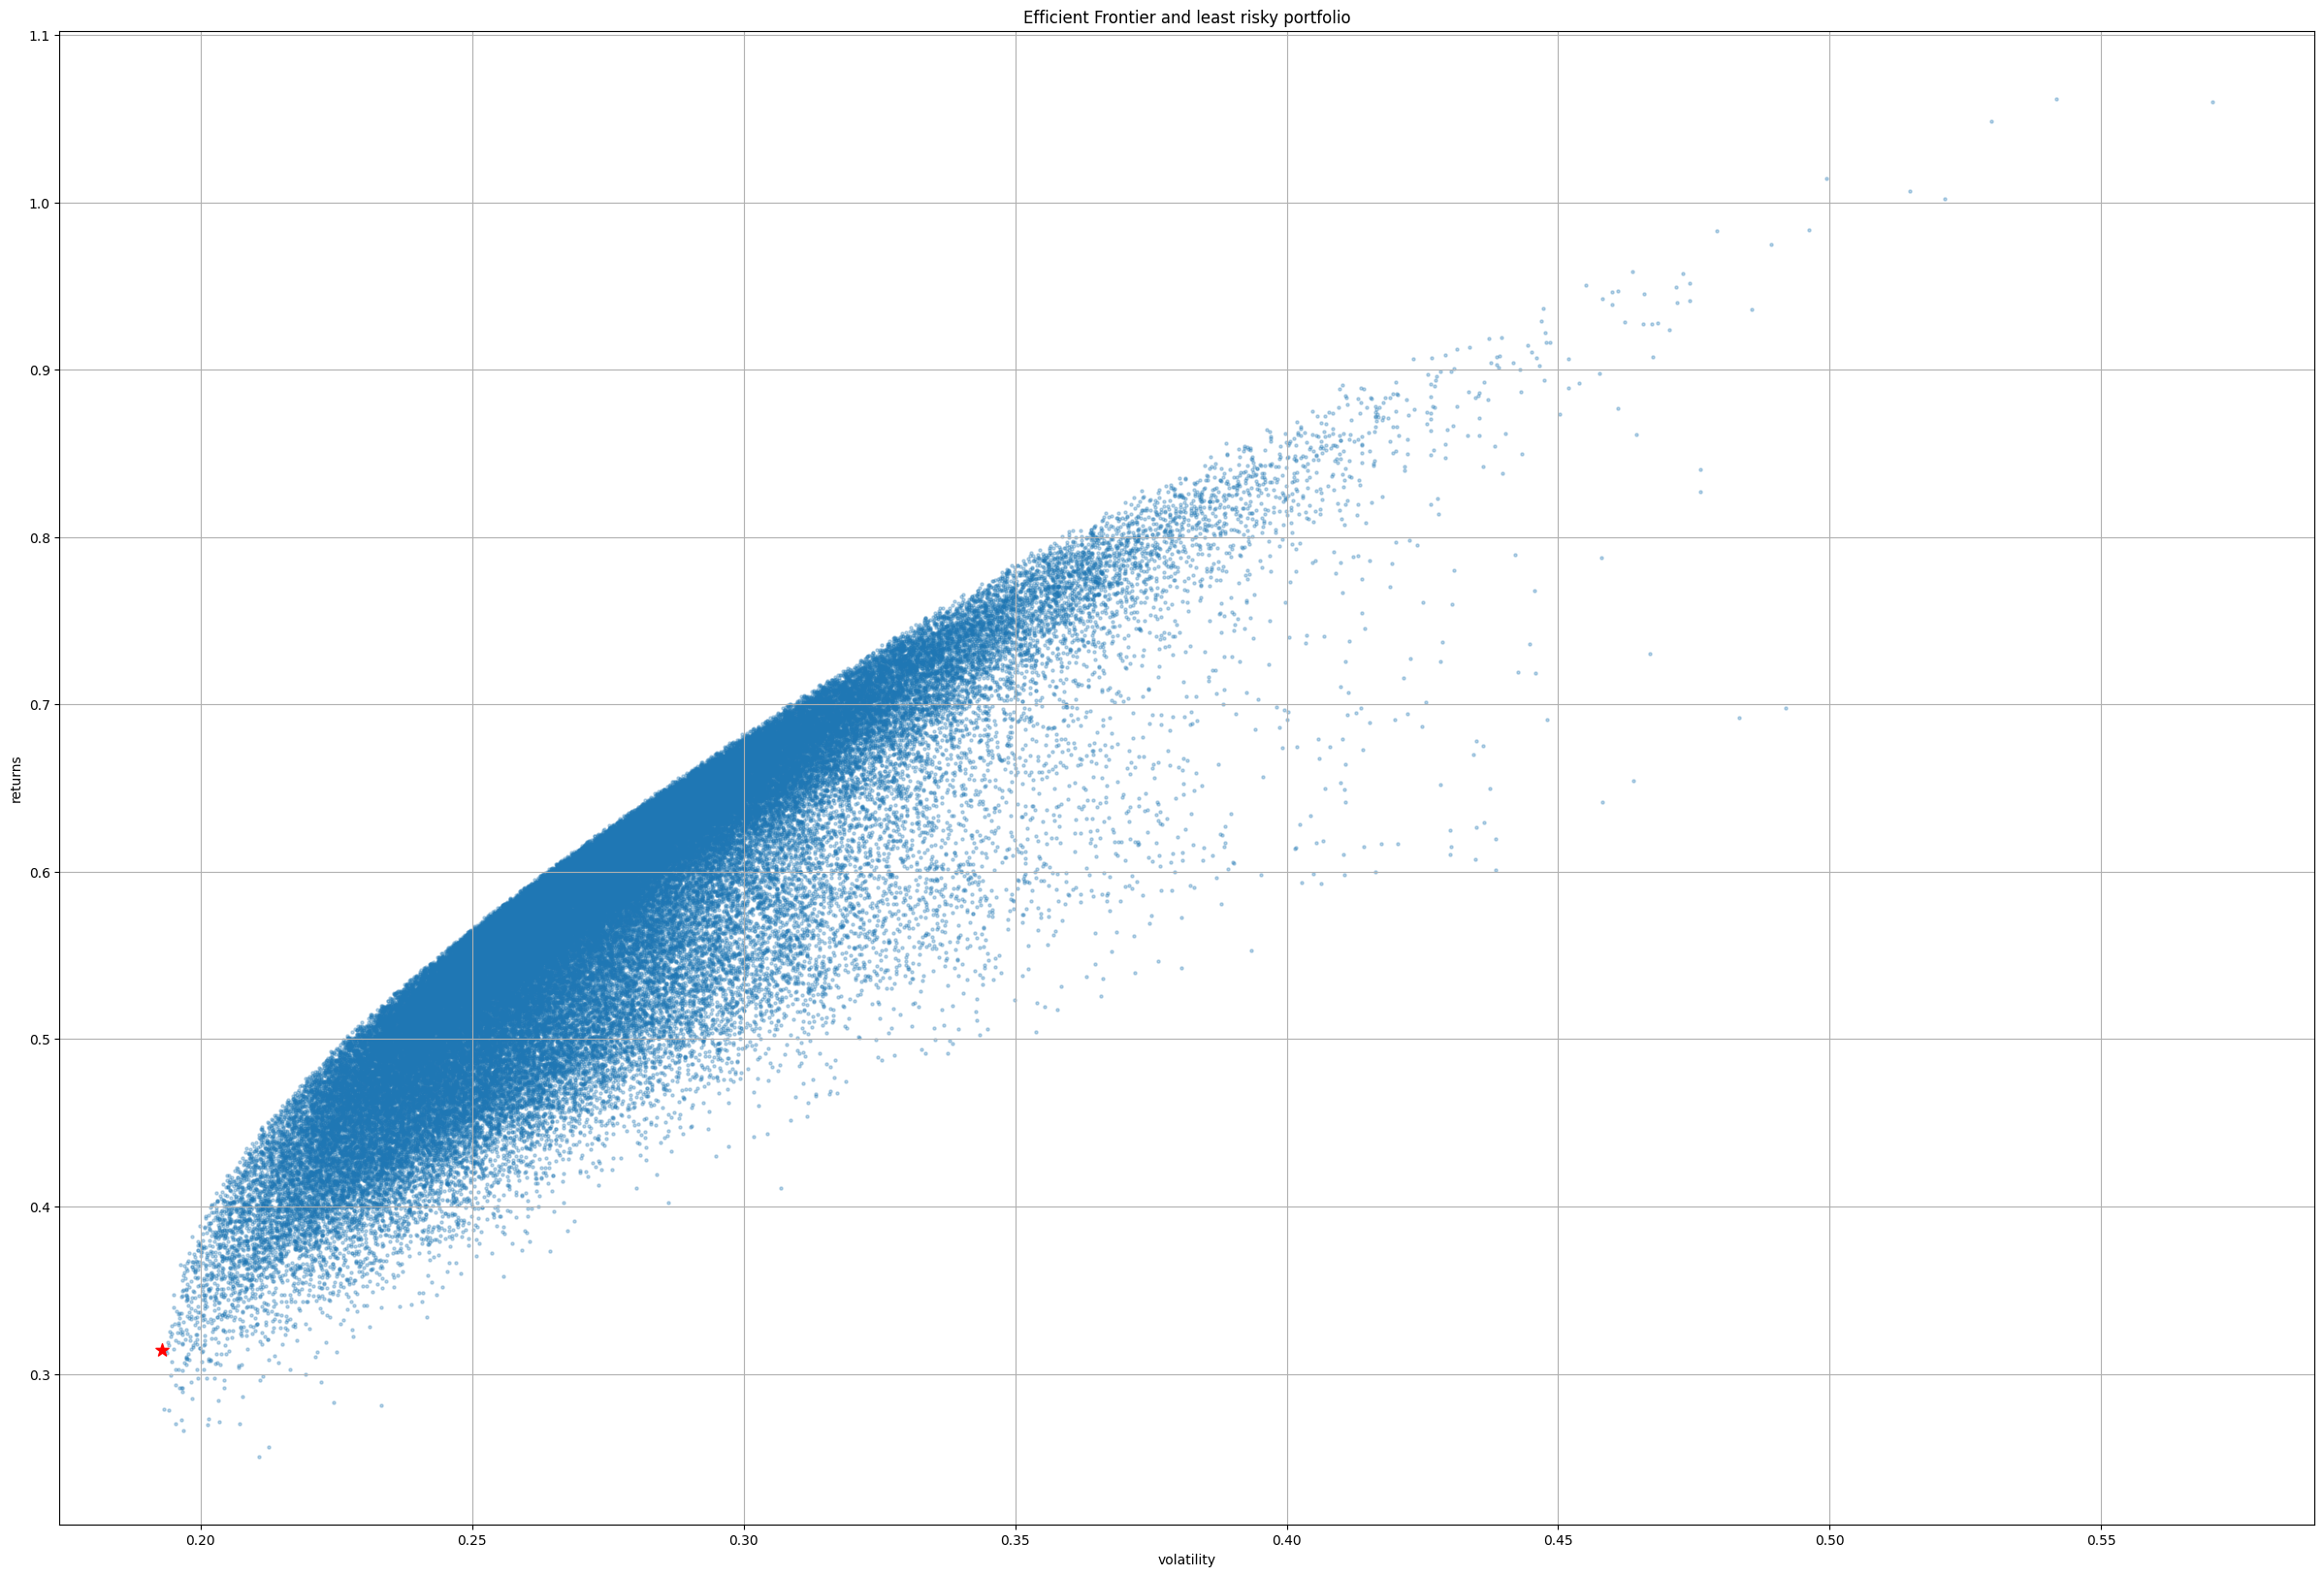

In [16]:
# portfolios with lowest volatility
min_var_port = portfolios.loc[portfolios['volatility'].idxmin()]

print('-'*100)
print('\nEfficient Frontier:')
print(min_var_port[:2])

portfolios.plot.scatter(x='volatility', y='returns', grid=True, marker='o', s=5, alpha=0.3, figsize=(30, 20))
plt.scatter(x=min_var_port[1], y=min_var_port[0], color='r', marker='*', s=100)
plt.title('Efficient Frontier and least risky portfolio');

In [17]:
print('-'*100)
print('\nTransverse results:')

portfolios.tail(10).T

----------------------------------------------------------------------------------------------------

Transverse results:


,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
returns,0.742110,0.659639,0.592408,0.549682,0.563449,0.644374,0.587978,0.482621,0.802863,0.675334
volatility,0.337797,0.304918,0.280221,0.252921,0.273362,0.319189,0.265981,0.227847,0.400994,0.303088
sharpe_ratio,2.194543,2.160706,2.111222,2.170176,2.058252,2.016278,2.207589,2.114675,2.000189,2.225537
AMR_weight,0.262047,0.323485,0.166342,0.203710,0.299259,0.253193,0.260345,0.110799,0.522597,0.229340
BAH_weight,0.034471,0.133403,0.158396,0.102108,0.331245,0.109141,0.257434,0.225551,0.269623,0.098686
CARR_weight,0.206414,0.168366,0.246854,0.064662,0.013925,0.092577,0.129796,0.094839,0.059556,0.138553
CEG_weight,0.146722,0.179877,0.315194,0.174364,0.087010,0.434347,0.129686,0.207991,0.052753,0.203637
TVK.TO_weight,0.061311,0.173730,0.037793,0.359803,0.243319,0.107936,0.161119,0.243820,0.053446,0.103623
UNTC_weight,0.289035,0.021139,0.075420,0.095354,0.025241,0.002806,0.061621,0.116999,0.042024,0.226162


In [18]:
print('-'*100)
print('\nPortfolio Optimized with best return under less volatility:')

min_var_port

----------------------------------------------------------------------------------------------------

Portfolio Optimized with best return under less volatility:


returns          0.314464
volatility       0.192888
sharpe_ratio     1.626142
AMR_weight       0.035965
BAH_weight       0.419342
CARR_weight      0.132049
CEG_weight       0.004816
TVK.TO_weight    0.344165
UNTC_weight      0.063663
Name: 84304, dtype: float64

In [19]:
sharpe_max = portfolios.loc[portfolios['sharpe_ratio'].idxmax()]

print('-'*100)
print('\nPortfolio Optimized:')
sharpe_max

----------------------------------------------------------------------------------------------------

Portfolio Optimized:


returns          0.621467
volatility       0.272487
sharpe_ratio     2.277787
AMR_weight       0.236109
BAH_weight       0.156349
CARR_weight      0.186076
CEG_weight       0.124450
TVK.TO_weight    0.154010
UNTC_weight      0.143006
Name: 67851, dtype: float64

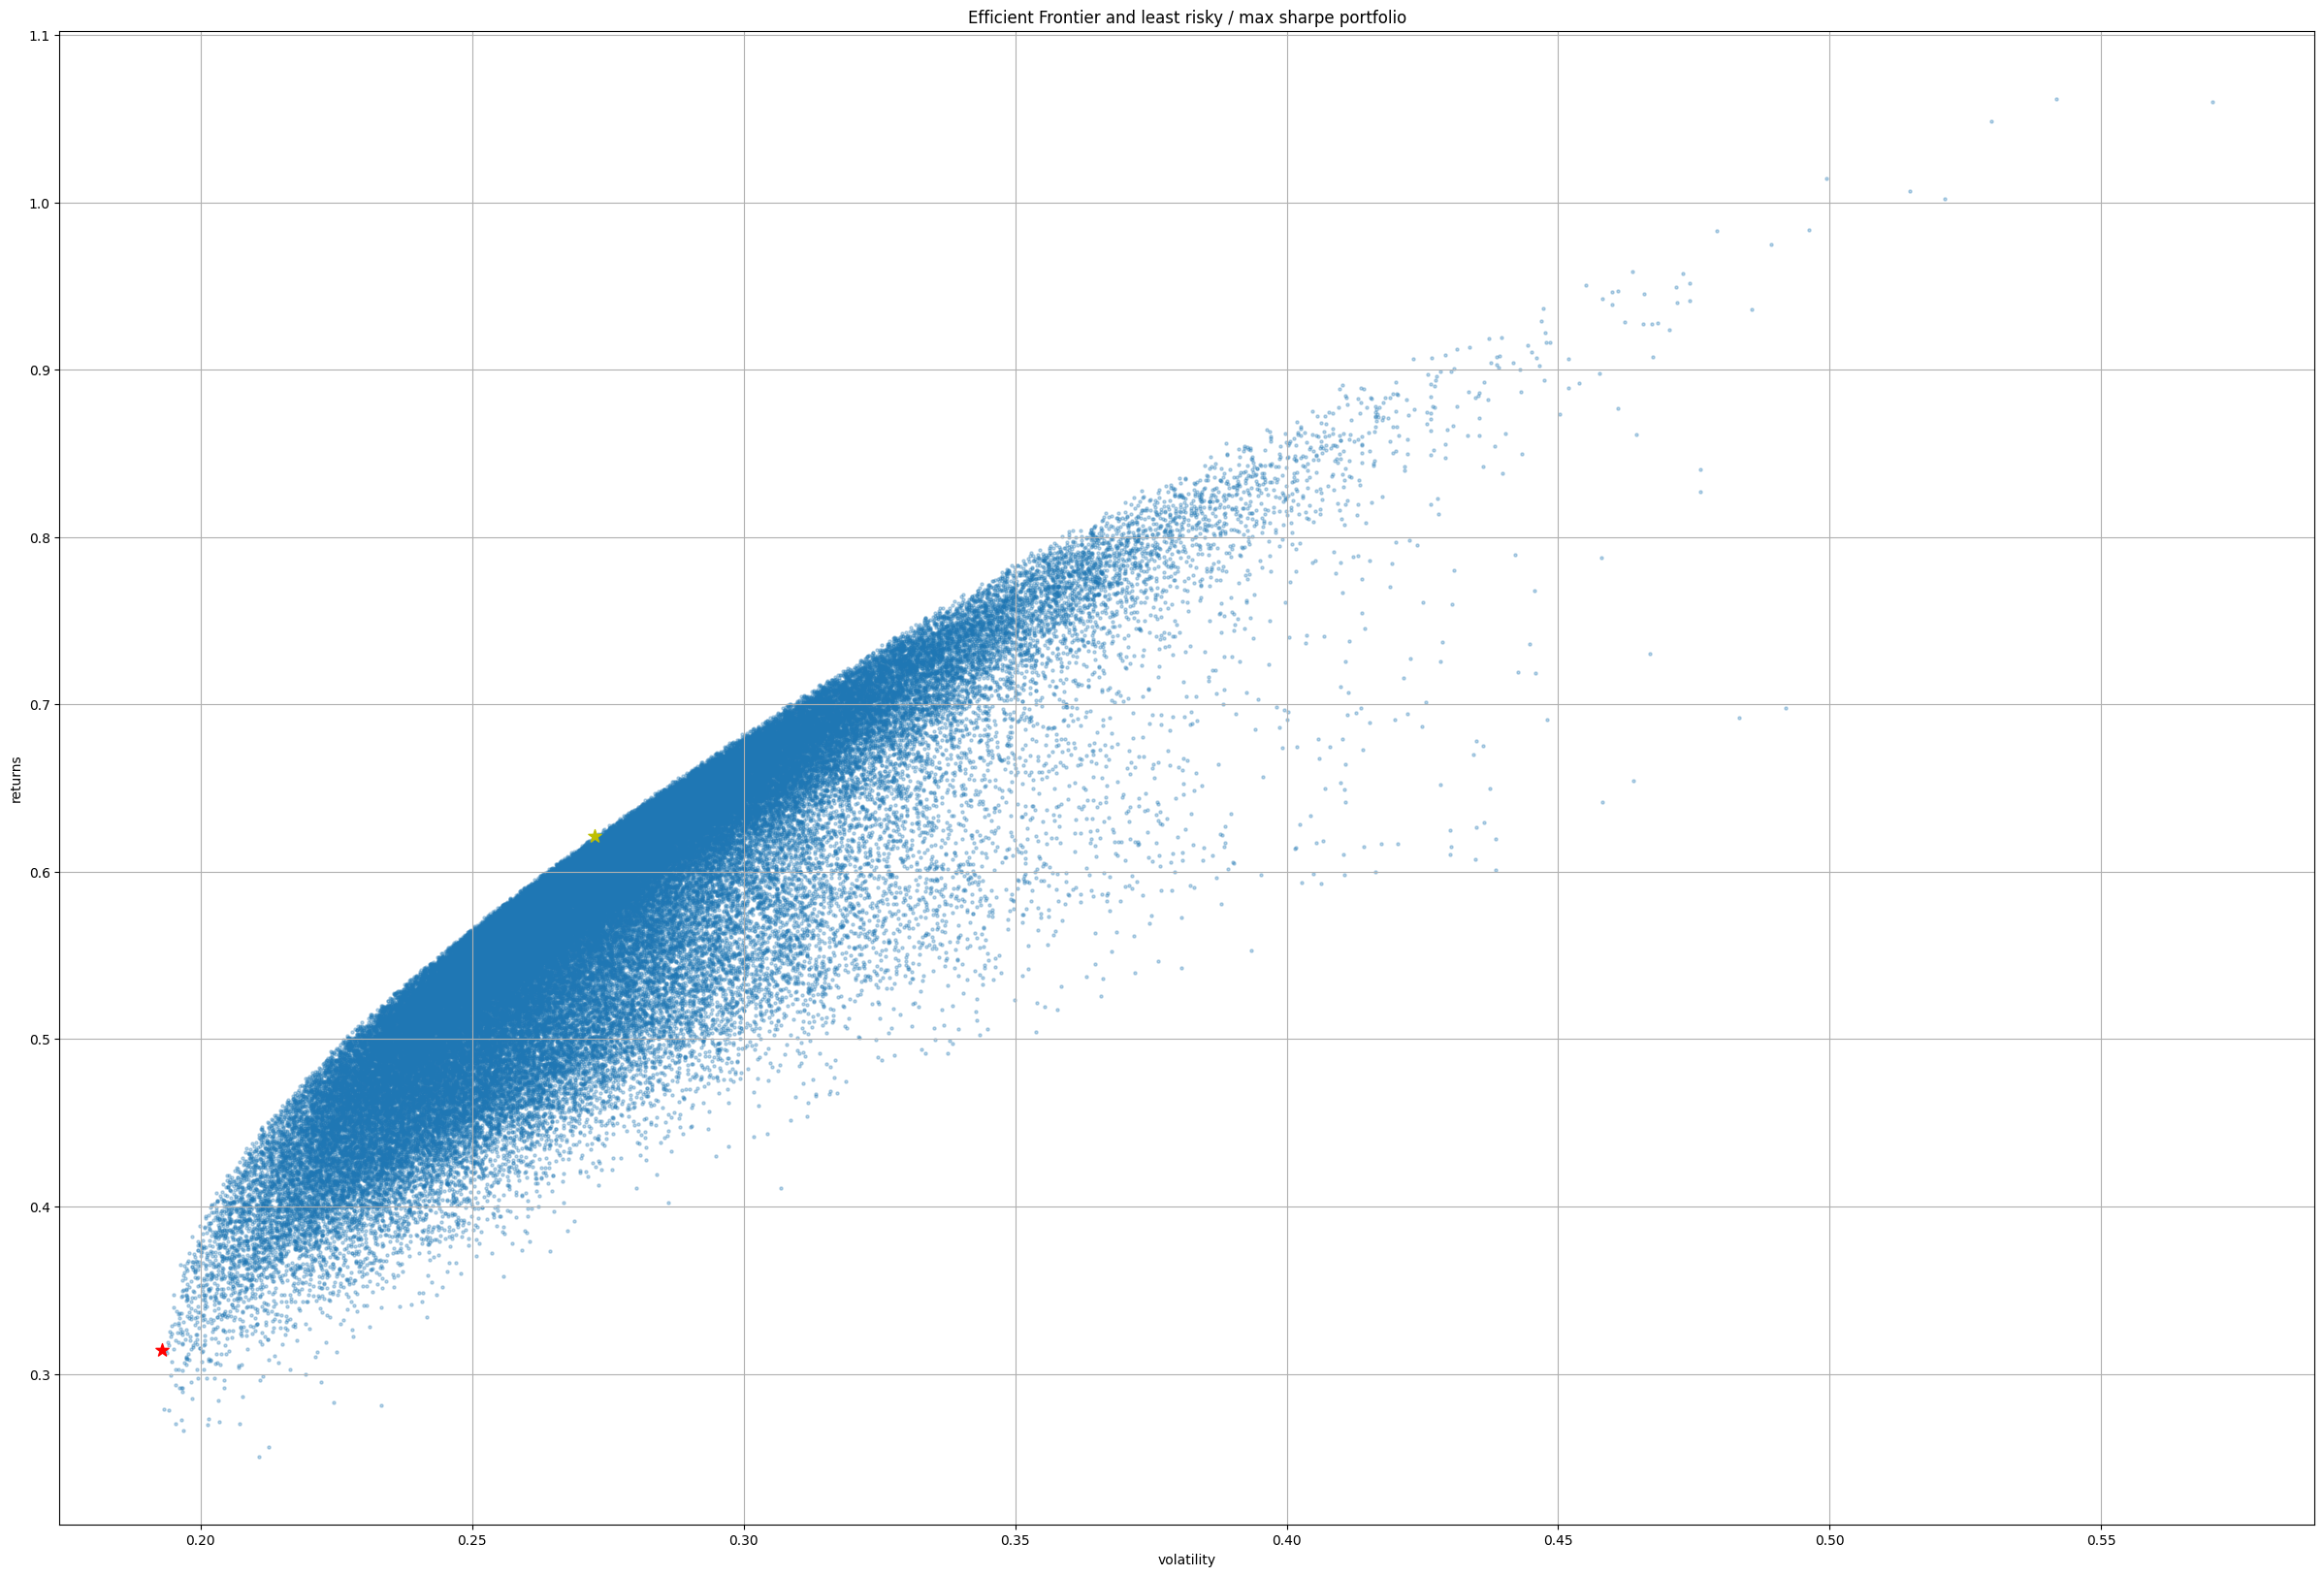

In [20]:
# plot the 
portfolios.plot.scatter(x='volatility', y='returns',grid=True, marker='o', s=5, alpha=0.3, figsize=(30, 20))
plt.scatter(x=min_var_port[1], y=min_var_port[0], color='r', marker='*', s=100);
plt.scatter(x=sharpe_max[1], y=sharpe_max[0], color='y', marker='*', s=100);
plt.title('Efficient Frontier and least risky / max sharpe portfolio');

In [21]:
cal_x = []
cal_y = []
utility = []
a = 2
max_returns = portfolios.returns.max()

returns = sharpe_max[0]
volatility = sharpe_max[1]

for er in np.linspace(RISK_FREE, max_returns, NUM_PORTFOLIOS):
    sd = (er - RISK_FREE)/((returns - RISK_FREE) / volatility)
    u = er - 0.5*a*(sd**2)
    cal_x.append(sd)
    cal_y.append(er)
    utility.append(u)
    
data2 = {'utility':utility, 'cal_y':cal_y, 'cal_x':cal_x}

cal = pd.DataFrame(data2)

print('-'*100)
print('\nUtility calculation:')
print(sharpe_max[:2])

cal.tail(10)

----------------------------------------------------------------------------------------------------

Utility calculation:
returns       0.621467
volatility    0.272487
Name: 67851, dtype: float64


,utility,cal_y,cal_x
99990,0.844817,1.061783,0.465795
99991,0.844824,1.061793,0.465800
99992,0.844830,1.061804,0.465805
99993,0.844836,1.061814,0.465809
99994,0.844842,1.061825,0.465814
99995,0.844849,1.061836,0.465819
99996,0.844855,1.061846,0.465823
99997,0.844861,1.061857,0.465828
99998,0.844867,1.061867,0.465833
99999,0.844874,1.061878,0.465837


In [22]:
investors_port = cal.iloc[cal['utility'].idxmax()]

print('-'*100)
print('\nUtility - Investors Portfolio:')
investors_port

----------------------------------------------------------------------------------------------------

Utility - Investors Portfolio:


utility    0.844874
cal_y      1.061878
cal_x      0.465837
Name: 99999, dtype: float64

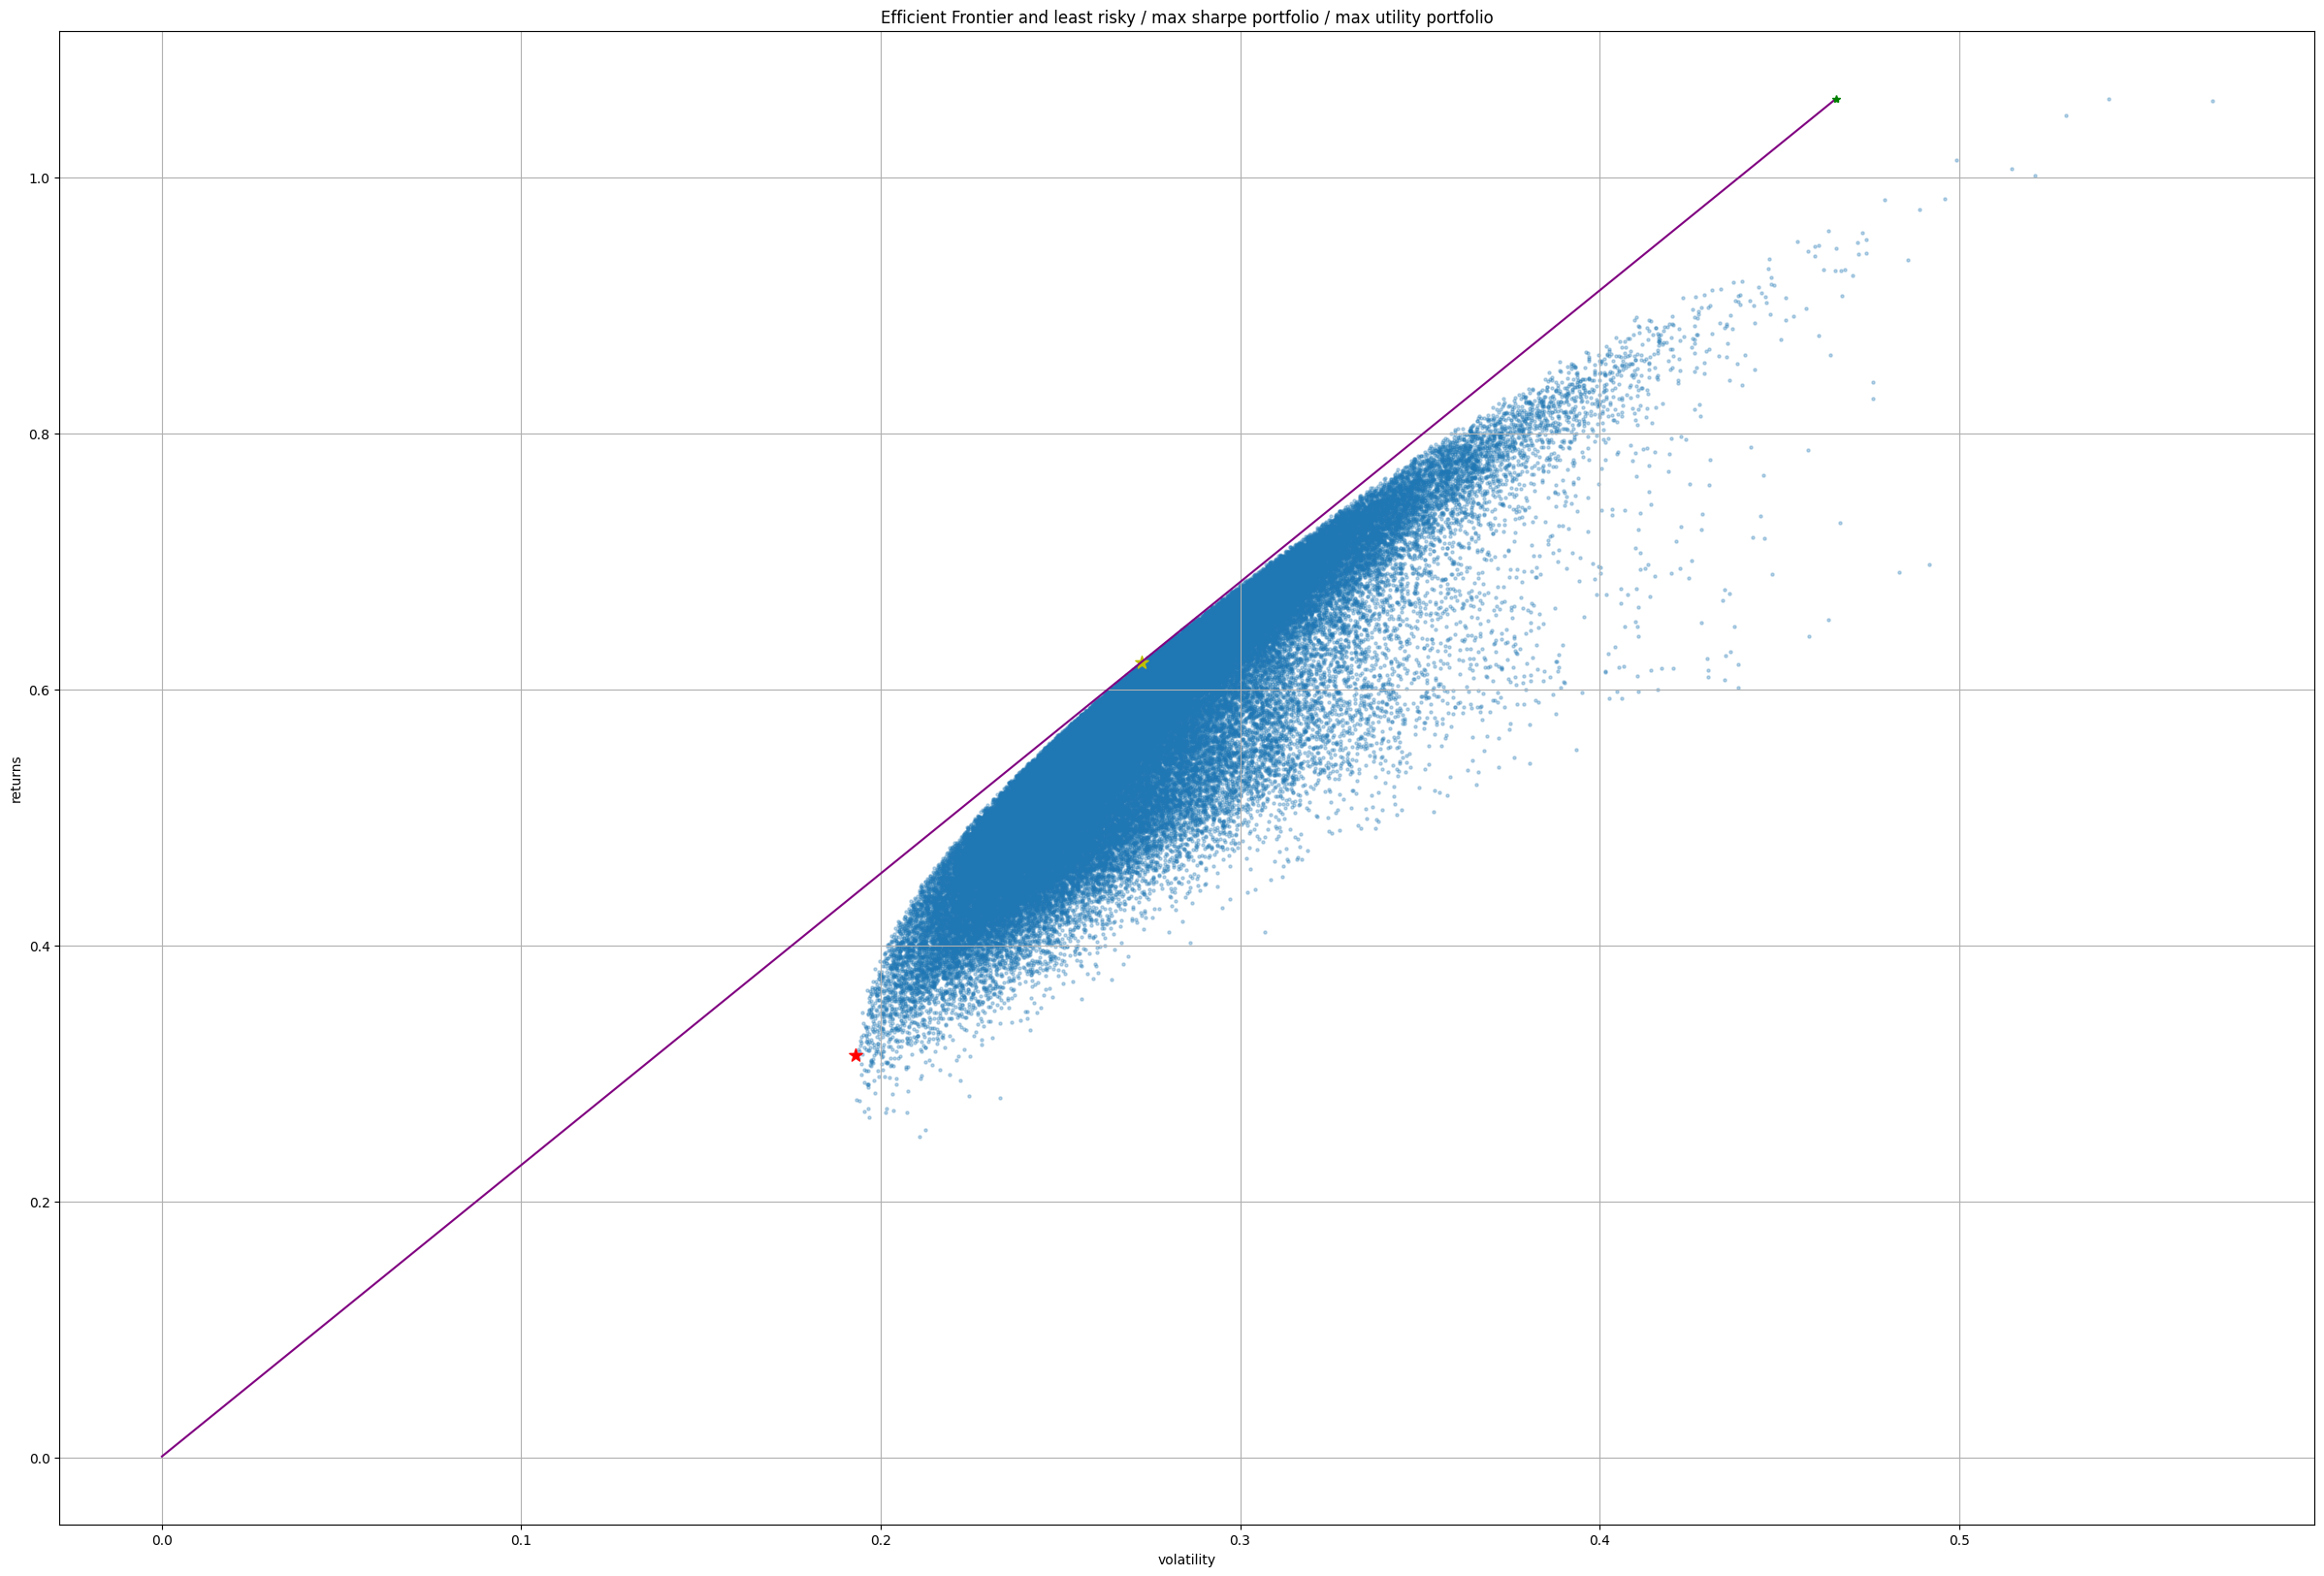

In [23]:
portfolios.plot.scatter(x='volatility', y='returns', grid=True, marker='o', s=5, alpha=0.3, figsize=(30, 20))
plt.scatter(x=min_var_port[1], y=min_var_port[0], color='r', marker='*', s=100)
plt.scatter(x=sharpe_max[1], y=sharpe_max[0], color='y', marker='*', s=100)
plt.plot(cal_x, cal_y, color='purple')
plt.plot(investors_port[2], investors_port[1], '*', color='green')
plt.title('Efficient Frontier and least risky / max sharpe portfolio / max utility portfolio');

In [24]:
# find weight of sharpe optimised portfolio
pct_risk = investors_port[2]/sharpe_max[1]

# find final returns, vol, weights of 
# sharpe optimised portfolio components
risk = sharpe_max[2:] * pct_risk

# find final returns, vol, weights of rf
risk_free = pd.Series([(1-pct_risk)], index=['Cash'])

port_fin = pd.concat([investors_port,risk,risk_free], axis=0).rename({'cal_y':'returns', 'cal_x':'volatility'})
port_fin

utility          0.844874
returns          1.061878
volatility       0.465837
sharpe_ratio     3.894050
AMR_weight       0.403645
BAH_weight       0.267290
CARR_weight      0.318112
CEG_weight       0.212757
TVK.TO_weight    0.263291
UNTC_weight      0.244480
Cash            -0.709576
dtype: float64

In [25]:
portfolios['utility'] = portfolios['returns'] - 0.5 * a * (portfolios['volatility']**2)
# find final returns, vol, weights of rf
risk_free = pd.Series([(0.0)], index=['Cash'])

print('---')
#portfolios = portfolios[-1:] + portfolios[:-1]
print('---')

optimal_portfolio = portfolios.loc[portfolios['utility'].idxmax()]
port_fin = pd.concat([optimal_portfolio, risk_free], axis=0)

print('-'*100)
print('\nUtility - Optimal:')
print(port_fin)

---
---
----------------------------------------------------------------------------------------------------

Utility - Optimal:
returns          1.061878
volatility       0.541753
sharpe_ratio     1.958603
AMR_weight       0.721026
BAH_weight       0.045073
CARR_weight      0.036779
CEG_weight       0.025429
TVK.TO_weight    0.007828
UNTC_weight      0.163865
utility          0.768382
Cash             0.000000
dtype: float64


In [26]:
print('-'*100)
print('\nComparing Utility:')

cal.utility.describe()

----------------------------------------------------------------------------------------------------

Comparing Utility:


count    100000.000000
mean          0.459004
std           0.244203
min           0.000800
25%           0.252507
50%           0.477088
75%           0.674544
max           0.844874
Name: utility, dtype: float64